In [153]:
%matplotlib inline
import os.path
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Near Real-time CO<sub>2</sub> Analysis
This notebook contains an analysis of the predicted CO<sub>2</sub> levels as described in [this paper](https://www.nature.com/articles/s41558-020-0797-x). Here, the variation in CO<sub>2</sub> during the Covid-19 lockdown has been estimated by calculating the change in activity across 6 sectors during the COVID-19 lockdown and using this as a proxy for CO_<sub>2</sub> emissions. The 6 sectors are:
1. Power
2. Industry
3. Surface Transport
4. Public Buildings and Commerce
5. Residential
6. Aviation
These categories align with the sectoral split provided by the International Energy Agency ([IEA](https://www.iea.org/)).

The predicted change in carbon emission has been calculated using the following formula
\begin{equation}
    \Delta CO_{2}^{c,s,d} = CO_{2}^{c} \times \delta S^{c} \times \Delta A^{s, d(CI,c)}
\end{equation}
where $\Delta CO_{2}^{c,s,d}$ is the mean daily emissions for the latest available year (2017-2019) updated from the [Global Carbon Project](https://www.globalcarbonproject.org/carbonbudget/19/data.htm) for world counties, $\delta S^{c}$ is the fraction of emissions in each sector calculated using data from the [IEA for each country](https://www.iea.org/data-and-statistics?country=WORLD&fuel=Energy%20supply&indicator=Total%20primary%20energy%20supply%20(TPES)%20by%20source), and $\Delta A^{s, d(CI,c)}$ is the fractional change in activity level for each sector compared with pre-COVID levels as a function of the Confinement Index (CI) for each day of the year and each country, state or province. Note that the superscripts $c, s, d$ indicate country, sector and day respectively.

## Assumptions
The file *PublicData_Countries_v6.xlsx* contains the data that will be plotted by this notebook. It is assumed that this file is located in the ./raw folder that is in the same directory as the .ipynb file, if this is not the case then an OSError exception is raised and the script will terminate.

In [154]:
#Parameters
file_name = "PublicData_Countries_v6.xlsx"
file_url  = ""
date_fmt  = "%Y-%m-%d %H:%M:%S"
sector_map = {
    "TOTAL_CO2": "TOTAL_CO2", 
    "PWR_CO2": "POWER", 
    "IND_CO2": "INDUSTRY", 
    "TRS_CO2": "SURFACE_TRANSPORT", 
    "PUB_CO2": "PUBLIC",
    "RES_CO2": "RESIDENTIAL", 
    "AVI_CO2": "AVIATION"}

In [155]:
#Check data is available
file_loc  = os.path.join(os.getcwd(), "raw")
file_path = os.path.join(file_loc, file_name)
if os.path.exists(file_path) is not True:
    #Attempt download from a URL
    raise OSError(f"Unable to proceed as the data file {name} could not be found in the directory {loc}")

## Data Import
The Excel file contains multiple sheets. The first sheet "\__KEY__" is a description of the data names, units, etc. and the second sheet "mean" is the baseline average CO<sub>2</sub> emission for each country during the year 2019. The rest of the sheets contain the predicted carbon emissions by sector for each country in the study, the final sheet "GLOBAL" is the predicted global carbon emissions by sector. 

We always import the region keys and the baseline data (the mean values of the CO<sub>2</sub> emissions by sector for 2019) as they are needed to normalise the emissions data and assign the correct labels when plotting. 

To avoid loading the entire Excel file we use the package `xlrd` to access the file data "on-demand", we use this capability to peek the country names in the study and provide them as a list to the user which they can choose from

In [156]:
#Import the key data
df_region = pd.read_excel(file_path, "__KEY__", usecols="G:H", skiprows=5, index_col=0)
df_region.head(10)

,Name
Code,
ARE,United Arab Emirates
ARG,Argentina
AUS,Australia
AUT,Austria
BEL,Belgium
BGD,Bangladesh
BGR,Bulgaria
BRA,Brazil
CAN,Canada


In [157]:
#Import the baseline
df_base = pd.read_excel(file_path, "mean", usecols="B:J", index_col=0, header=0) #should be able to use skip_rows=[0,1] but didn't work!
df_base.drop(index="None", inplace=True)
df_base.head(10)

,REGION_NAME,TOTAL_CO2,POWER,INDUSTRY,SURFACE_TRANSPORT,PUBLIC,RESIDENTIAL,AVIATION
REGION_CODE,,,,,,,,
ALB,Albania,0.012846,0.000538379,0.00484541,0.00565924,0.0011018,0.000651063,5.00818e-05
DZA,Algeria,0.432618,0.146766,0.06485,0.137806,0.011946,0.0665566,0.00469309
AGO,Angola,0.104179,0.0302792,0.015802,0.0362404,0.009273,0.00747518,0.00510961
ARG,Argentina,0.552309,0.198746,0.0964265,0.135533,0.0439276,0.0637486,0.0139283
ARM,Armenia,0.0157517,0.00360213,0.00174001,0.00480793,0.00164843,0.00348003,0.000473161
AUS,Australia,1.19734,0.672353,0.122037,0.268251,0.0391439,0.027631,0.0679261
AUT,Austria,0.1951,0.0581149,0.0367935,0.0690586,0.00566054,0.0190571,0.00641528
AZE,Azerbaijan,0.102704,0.0456574,0.00786154,0.0214681,0.00503945,0.0179404,0.00473708
BHR,Bahrain,0.0897731,0.0670533,0.00680744,0.010977,0,0.000765837,0.00416956


In [158]:
#Peek the sheetnames
xls = xlrd.open_workbook(file_path, on_demand=True)
sheet_names = xls.sheet_names()
sheet_names = [x for x in sheet_names if x not in ["__KEY__", "mean"]]
print(f"Select one country to plot the predicted carbon dioxide emissions:\n\n{sheet_names}")

Select one country to plot the predicted carbon dioxide emissions:

['ARE', 'ARG', 'AUS', 'AUT', 'BEL', 'BGD', 'BGR', 'BRA', 'CAN', 'CHL', 'CHN', 'COL', 'CYP', 'CZE', 'DEU', 'DNK', 'DZA', 'EGY', 'ESP', 'EST', 'EUandUK', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISR', 'ITA', 'JPN', 'KAZ', 'KOR', 'KWT', 'LTU', 'LUX', 'LVA', 'MAR', 'MEX', 'MYS', 'NGA', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PHL', 'POL', 'PRT', 'QAT', 'ROU', 'RUS', 'SAU', 'SVK', 'SVN', 'SWE', 'THA', 'TKM', 'TUR', 'UKR', 'USA', 'UZB', 'VEN', 'VNM', 'ZAF', 'GLOBAL']


## Specify a single country to plot data for

In [159]:
#Specify the country to plot data for
country_list = "GBR"

In [160]:
df = pd.read_excel(file_path, country_list, index_col=4, header=0) #should be able to use skip_rows=[0,1] but didn't work!
df.drop(index="Date", columns=["REGION_ID", "REGION_CODE", "REGION_NAME", "TIME_POINT"], inplace=True)
df.index = pd.to_datetime(df.index, format=date_fmt)

tiny_val = df.abs().max().max() * 1e-6

#Replace any 0 terms to allow plt.fill_between to work correctly
low_tok  = [x for x in df.columns if x.endswith("LOW")]
high_tok = [x for x in df.columns if x.endswith("HIGH")]
for tok in low_tok:
    df[tok].replace(0, -1.0 * tiny_val, inplace=True)
for tok in high_tok:
    df[tok].replace(0, 1.0 * tiny_val, inplace=True)

# * * This fails due to "chained assignment" * *   
#df[high_tok].replace(0, np.NaN) #, inplace=True)
#df[low_tok].replace(0, -1e-10)#, inplace=True)
#df.replace(0, np.NaN, inplace=True)

df.head(10)

,TOTAL_CO2_MED,PWR_CO2_MED,IND_CO2_MED,TRS_CO2_MED,PUB_CO2_MED,RES_CO2_MED,AVI_CO2_MED,TOTAL_CO2_LOW,PWR_CO2_LOW,IND_CO2_LOW,...,PUB_CO2_LOW,RES_CO2_LOW,AVI_CO2_LOW,TOTAL_CO2_HIGH,PWR_CO2_HIGH,IND_CO2_HIGH,TRS_CO2_HIGH,PUB_CO2_HIGH,RES_CO2_HIGH,AVI_CO2_HIGH
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-02,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-03,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-04,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-05,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-06,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-07,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-08,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07
2020-01-09,0,0,0,0,0,0,0,-4.715152e-07,-4.715152e-07,-4.715152e-07,...,-4.715152e-07,-4.715152e-07,-4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07,4.715152e-07


In [161]:
#Grab the baseline data & country name
df_sector_base = df_base.loc[country_list]
country_name   = df_region.loc[country_list]

Text(0, 0.5, 'Change in $\\mathregular{CO_{2}}$ [MT$\\mathregular{CO_{2}}$/day]')

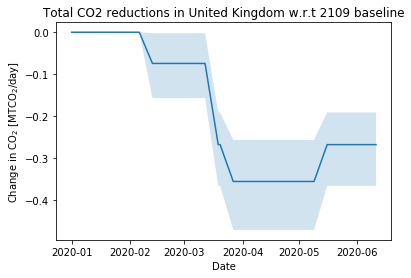

In [162]:
#Plot the data for the total change in CO2
fig, ax = plt.subplots()
plt.plot(df.index.values, df["TOTAL_CO2_MED"].values)
ax.fill_between(df.index.values, df["TOTAL_CO2_LOW"].values, df["TOTAL_CO2_HIGH"].values, alpha=0.2)
ax.set_title(f'Total CO2 reductions in {country_name[0]} w.r.t 2109 baseline')
ax.set_xlabel('Date')
ax.set_ylabel('Change in $\mathregular{CO_{2}}$ [MT$\mathregular{CO_{2}}$/day]')

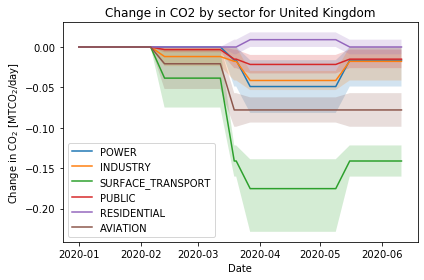

In [163]:
#Plot the data for each sector in units of MTCO2/day
cols = [x for x in df.columns if x.endswith("_MED")]
cols.remove("TOTAL_CO2_MED")

fig, axes = plt.subplots()
for ii, tok in enumerate(cols):      
    grp       = tok[:-4]
    bound_tok = [x for x in df.columns if x.startswith(grp)]
    bound_tok = [x for x in bound_tok if x is not tok]    
    lab_str   = [v for k, v in sector_map.items() if k.startswith(grp)]
    
    axes.plot(df.index.values, df[tok].values, label=lab_str[0])
    axes.fill_between(df.index.values, df[bound_tok[0]].values, df[bound_tok[1]].values, alpha=0.2)

axes.set_title(f"Change in CO2 by sector for {country_name[0]}")    
axes.set_xlabel('Date')
axes.set_ylabel('Change in $\mathregular{CO_{2}}$ [MT$\mathregular{CO_{2}}$/day]')
plt.legend()

plt.tight_layout()
plt.show()

    

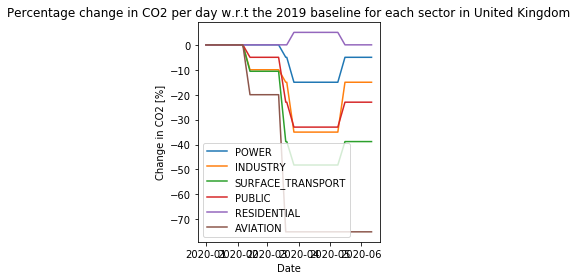

In [164]:
#Plot the normalised data
fig, axes = plt.subplots()
for ii, tok in enumerate(cols):      
    grp     = tok[:-4]
    lab_str = [v for k, v in sector_map.items() if k.startswith(grp)]
    
    #Normalise w.r.t the 2019 baseline
    norm_val = 100 * df[tok].values / df_sector_base[lab_str].values  
    
    axes.plot(df.index.values, norm_val, label=lab_str[0])
    
axes.set_title(f"Percentage change in CO2 per day w.r.t the 2019 baseline for each sector in {country_name[0]}")
axes.set_xlabel('Date')
axes.set_ylabel(f'Change in CO2 [%]')
plt.legend()
plt.tight_layout()
plt.show()

## Summary
The data presented in this workbook plots the predicted in change in CO<sub>2</sub> due to the COVID-19 lockdown using the data found in [this paper](https://www.nature.com/articles/s41558-020-0797-x). For the case of the UK, their model predicts that transport (aviation and surface) will see a large drop in CO<sub>2</sub> output as a result of the lockdown measures, with maximum decreases of 75% and 47% respectively. Output from industry and public sector will also see a decrease of around 35% each and power consumption will drop by a maximum of 15%. Note that all percentages are with respect to the average daily change in CO<sub>2</sub> for the year 2019 (the last available year on records).

The method used here is to proxy the real-time CO<sub>2</sub> emmissions (as they are not available) and instead make a prediction for the change in CO<sub>2</sub> by modelling the change in activity for each sector. This is is a sensible approach, however as the method has been applied globally it relies on data being globally available which is obviously not the case. Instead, for certain countries the change in activity for a given sector has been modelled using the activity data from another country, an improvement on this would be to use accurate data for each country. A breakdown of the data used to model activity in each sector is given below:
1. Power - Derived from electricity data
2. Industry - Derived from industrial data from China and steel production in United States
3. Surface Transport - Derived from traffic data
4. Public Buildings and Commerce  - Assumptions based on the level of confinement
5. Residential - Derived from UK smart meters
6. Aviation - Derived from number of flights
The data for power, surface transport, aviation and residential activity are based on country-specific datasets for which the UK has a reasonably good set of data. That being said, data was only used up until the 15 April, so it might be that including another 2 months of data in the datset provides an improved estimate using these methods.

## Recommendations
* Investigate a more granular way of quantifying the lockdown measures. 
    + Look at the specific points in time where the lockdown measures were implemented and observe changes 
    + This study only used three levels for describing the lockdown measures, Alex mentioned an "Oxford Index" that may be more appropriate.
* Use several detailed data sources available for the UK to measure the change in activity across these 6 sectors.
* Compare the predicted values with the actual data from satellites or weather stations.
